In [1]:
import torch
import torchvision
from torch import nn
from transformers import AutoTokenizer, CLIPModel, CLIPVisionModelWithProjection
from train_c_lora import WurstCore
from train_b import WurstCore as WurstCoreB
from warp_core.utils import load_or_fail
import yaml
import matplotlib.pyplot as plt
from PIL import Image
import requests
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# SETUP WARPCORE
config_file = 'configs/finetune_c_3b_lora.yml'
with open(config_file, "r", encoding="utf-8") as file:
    loaded_config = yaml.safe_load(file)
    loaded_config['use_fsdp'] = False
    loaded_config['batch_size'] = 1
    loaded_config['grad_accum_steps'] = 1

warpcore = WurstCore(
    config_dict=loaded_config,
    device=device
)

# STAGE B
config_file_b = 'configs/finetune_b_3b.yml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    config_file_b['use_fsdp'] = False
    config_file_b['batch_size'] = 1
    loaded_config['grad_accum_steps'] = 1
    
warpcore_b = WurstCoreB(
    config_dict=config_file_b,
    device=device
)

In [3]:
# SETUP MODELS & DATA
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)
models = warpcore.setup_models(extras)
models.generator.bfloat16().eval().requires_grad_(False)
print("CONTROLNET READY")

extras_b = warpcore_b.setup_extras_pre()
models_b = warpcore_b.setup_models(extras_b)
models_b.generator.bfloat16().eval().requires_grad_(False)
print("STAGE B READY")
pass

Training with batch size 1 (1/GPU)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModelWithProjection: ['text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.5.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.8.self_attn.k_proj.weight', 'text_model.encoder.layers.6.mlp.fc1.weight', 'text_model.encoder.layers.11.mlp.fc1.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.5.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.7.mlp.fc2.weight', 'text_model.encoder.layers.8.mlp.fc2.weight', 'text_model.encoder.layers.9.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.k_proj.bias', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.10.mlp.fc1.weight', 'text_m

Updating tokens: [(49408, '[fernando]')]
LoRA training 128 layers
CONTROLNET READY


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


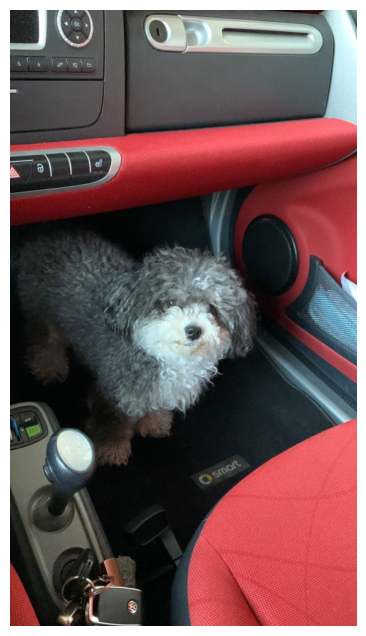

['a photo of a dog [fernando]']


In [4]:
# PREVIEW BATCH
batch = next(data.iterator)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'])

In [5]:
print(models.lora.embeddings.embeddings)
print(models.clip_text_model.embeddings.token_embedding.weight[-1])

for k, v in models.clip_tokenizer.vocab.items():
#     if re.search("^dog</w>", k) is not None:
    if re.search("^(brad</w>|pit</w>)$", k) is not None:
        print(k, v)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)
tensor([-0.0215, -0.0067, -0.0076,  ...,  0.0334, -0.0036, -0.0086],
       device='cuda:0', grad_fn=<SelectBackward0>)
pit</w> 7476
brad</w> 9405


In [7]:
models.lora.load_state_dict(load_or_fail('/weka/home-warp/models/v3_release/stage_c_3b_lora/lora_10k.safetensors'))
pass

In [8]:
enable_lora = True
models.lora.embeddings.enabled = enable_lora
for i in range(len(models.lora.weights)):
    models.lora.weights[i].enabled = enable_lora


In [13]:
# PREPARE CONDITIONS
batch['captions'] = ['watercolor painting of a dog [fernando] on the beach'] * 4
batch['images'] = batch['images'][0:1].expand(4, -1, -1, -1)
conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    


{'cfg': 4, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f556e1ce6a0>, 'shift': 1, 'timesteps': 20}
torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 192, 192])


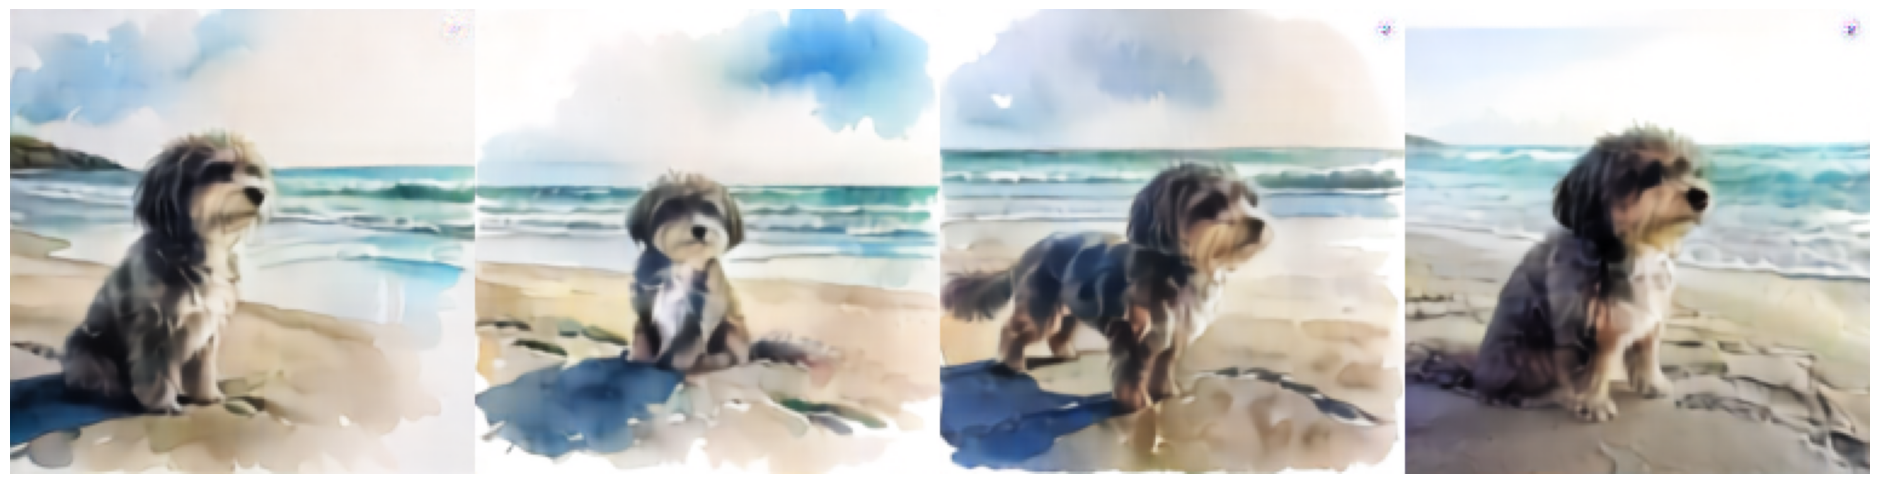

In [14]:
# SAMPLE
extras.sampling_configs['cfg'] = 4
# extras.sampling_configs['shift'] = 1
# extras.sampling_configs['timesteps'] = 20
# extras.sampling_configs['t_start'] = 1.0
print(extras.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents, _, _) = extras.gdf.sample(
        models.generator, conditions, (4, 16, 24, 24),
        unconditions, device=device, **extras.sampling_configs
    )
    sampled = models.previewer(sampled_latents).float()
    print(sampled_latents.shape, sampled.shape)
    
plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in sampled.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

In [15]:
conditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=False, eval_image_embeds=False)
unconditions_b = warpcore_b.get_conditions(batch, models_b, extras_b, is_eval=True, is_unconditional=True, eval_image_embeds=False)
conditions_b['effnet'] = sampled_latents
unconditions_b['effnet'] = torch.zeros_like(sampled_latents)

{'cfg': 1.5, 'sampler': <gdf.samplers.DDPMSampler object at 0x7f569d62b7f0>, 'shift': 1, 'timesteps': 10}
torch.Size([4, 16, 24, 24]) torch.Size([4, 3, 1024, 1024])


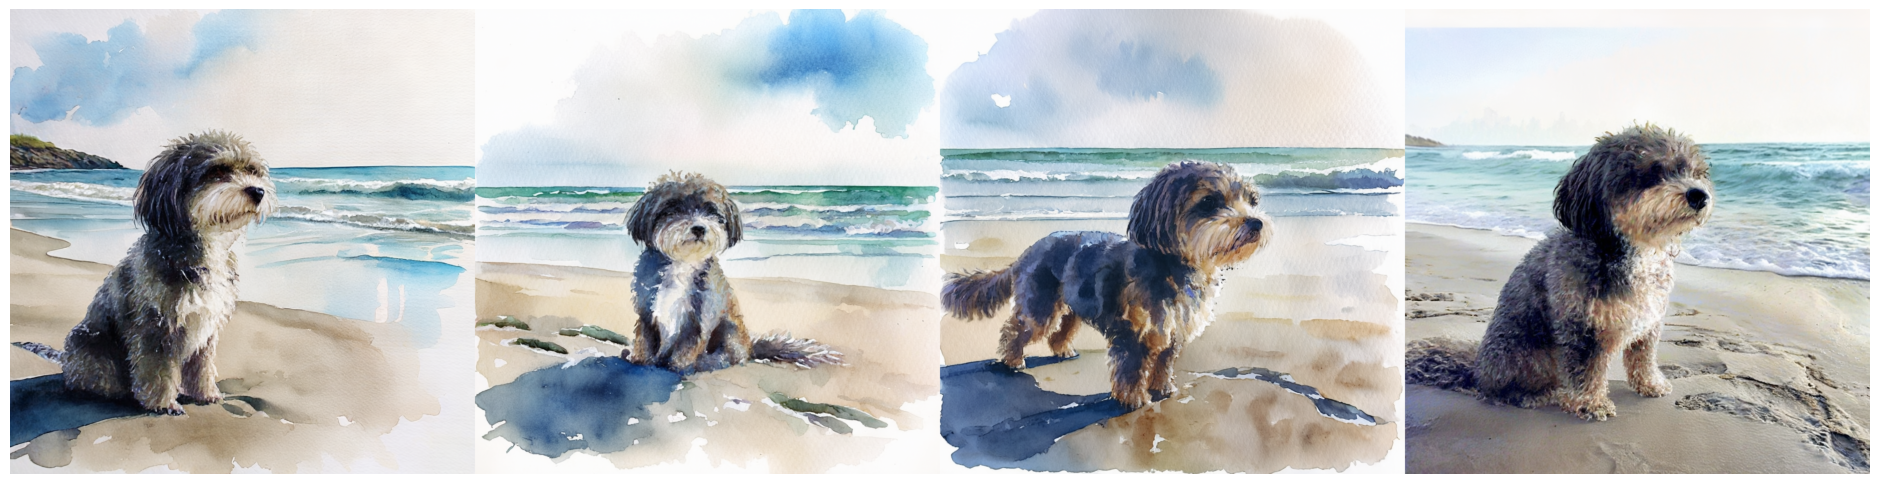

In [16]:
# SAMPLE
# extras_b.sampling_configs['cfg'] = 1.5
# extras_b.sampling_configs['shift'] = 1
# extras_b.sampling_configs['timesteps'] = 10
# extras_b.sampling_configs['t_start'] = 1.0
print(extras_b.sampling_configs)

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16), torch.random.fork_rng():
    torch.manual_seed(42)
    
    *_, (sampled_latents_b, _, _) = extras_b.gdf.sample(
        models_b.generator, conditions_b, (4, 4, 256, 256), # (4, 4, 256, 256),
        unconditions_b, device=device, **extras_b.sampling_configs
    )
    sampled_b = models_b.stage_a.decode(sampled_latents_b).float()
    print(sampled_latents.shape, sampled_b.shape)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in sampled_b.cpu().clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()